# Deep Multi-Layer Neural Network Framework Implementation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1eVFGPcVBbg4qrIevQ7OccbskGzrcvo81)

## Project Overview

Implementation of a comprehensive deep learning framework from scratch using TensorFlow primitives, featuring modular layer architecture, multiple activation functions, advanced optimizers, and extensive model comparison. This project demonstrates advanced neural network concepts including object-oriented design patterns, gradient computation, and systematic hyperparameter evaluation.

## Contributors
- Abolfazl Ranjbar - [GitHub](https://github.com/ImRanjbar)
- Miaad Kimiagari - [GitHub](https://github.com/Miaad2004)
- Taha Najaf - [GitHub](https://github.com/taha-najaf)

## Objectives

- Implement modular neural network framework with abstract base classes
- Design multiple activation functions (ReLU, Sigmoid, Tanh, Softmax)
- Implement advanced optimizers (SGD, Momentum, Adam)
- Create flexible model architecture supporting arbitrary depth
- Conduct comprehensive model comparison across different configurations
- Evaluate performance using multiple metrics and visualization techniques

## Technical Architecture

**Framework Design**: Object-oriented modular architecture with abstract base classes  
**Layer Types**: Dense layers with configurable neuron counts  
**Activation Functions**: ReLU, Sigmoid, Tanh, Softmax with analytical derivatives  
**Optimizers**: SGD, Momentum (with velocity), Adam (with bias correction)  
**Loss Function**: Categorical Cross-Entropy with numerical stability  
**Model Configurations**: 6 different architectures for systematic comparison  
**Implementation**: Pure TensorFlow core operations with custom gradient computation

## Dataset Preparation for Deep Learning

Loading complete CIFAR-10 dataset for advanced neural network experimentation. The preprocessing maintains consistency with previous implementations while preparing data for extensive model comparison across multiple deep learning architectures.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train, y_test = y_train.flatten(), y_test.flatten()

y_train_one_hot = to_categorical(y_train, 10)
y_test_one_hot = to_categorical(y_test, 10)

x_train_flat = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test_flat = x_test.reshape(x_test.shape[0], -1) / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


## Visualization and Analysis Utilities

Comprehensive visualization system for comparative analysis of multiple neural network architectures. The plotting utilities enable simultaneous monitoring of training/validation loss and accuracy across different model configurations for systematic performance evaluation.

In [2]:
import math
from sklearn.metrics import f1_score, confusion_matrix


def plot_all_model_histories(models_dict):
    n = len(models_dict)
    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
    axes = axes.flatten()

    for idx, (key, model) in enumerate(models_dict.items()):
        ax = axes[idx]
        ax2 = ax.twinx()

        ax.plot(model.train_loss_hist, label='Train Loss', linestyle='-')
        ax.plot(model.val_loss_hist, label='Val Loss', linestyle='--')
        ax2.plot(model.train_acc_hist, label='Train Acc', linestyle='-', color='green')
        ax2.plot(model.val_acc_hist, label='Val Acc', linestyle='--', color='red')

        ax.set_title(key, fontsize=10)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax2.set_ylabel("Accuracy")

        if idx == 0:
            ax.legend(loc='upper left')
            ax2.legend(loc='upper right')

    # Hide unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle("Training/Validation Loss & Accuracy per Model", fontsize=16, y=1.02)
    plt.show()


## Deep Learning Framework Implementation

Complete object-oriented neural network framework featuring abstract base classes for layers, activations, losses, and optimizers. The implementation includes advanced concepts such as automatic differentiation, multiple optimization algorithms, and modular architecture design enabling flexible model construction and experimentation.

In [3]:
import tensorflow as tf
from tqdm.notebook import trange
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import math
import abc
from typing import List

class Layer(abc.ABC):
    def __init__(self, n_neurons):
        self.n_neurons = n_neurons
        self.W: tf.Variable | None = None
        if n_neurons:
            self.b = tf.Variable(tf.zeros((1, n_neurons), tf.float32))
        else:
            self.b = None
        self._built: bool = False

    @abc.abstractmethod
    def build(self, input_shape):
        pass

    @abc.abstractmethod
    def forward(self, x: tf.Tensor, training: bool) -> tf.Tensor:
      pass

    @abc.abstractmethod
    def backward(self, prev_grads: tf.Tensor) -> tf.Tensor:
      pass

    def __call__(self, x: tf.Tensor, training: bool) -> tf.Tensor:
        if not self._built:
            self.build(x.shape)
            self._built = True

        return self.forward(x, training)

class Dense(Layer):
    def __init__(self, n_neurons):
        super().__init__(n_neurons)

    def build(self, input_shape):
        in_dim = input_shape[-1]
        std = tf.sqrt(2.0 / in_dim)
        self.W = tf.Variable(tf.random.normal((in_dim, self.n_neurons), stddev=std))

    def forward(self, x: tf.Tensor, training=False) -> tf.Tensor:
        self.x = x
        return tf.matmul(x, self.W) + self.b

    def backward(self, prev_grads: tf.Tensor) -> tf.Tensor:
        self.dW = tf.matmul(tf.transpose(self.x), prev_grads)       # prev_grads -> (batch, out_size), x-> (batch, in_dim)

        self.db = tf.reduce_sum(prev_grads, axis=0, keepdims=True)    # sum over the batch

        # w -> (in_dim, out_dim(n_neurons)), prev_grads -> (batch, out_dim)
        return tf.matmul(prev_grads, tf.transpose(self.W))    # wrt input of this layer


class Activation(Layer):
    def __init__(self):
        super().__init__(None)

    def build(self, input_shape):
        pass

    @abc.abstractmethod
    def _func(self, x):
      pass

    @abc.abstractmethod
    def _func_backward(self, x):
      pass

    def forward(self, x: tf.Tensor, training=False):
        self.x = x
        return self._func(x)

    def backward(self, prev_grads: tf.Tensor):
        return prev_grads * self._func_backward(self.x)

class ReLU(Activation):
    def __init__(self):
        super().__init__()

    def _func(self, x):
        return tf.maximum(x, 0.0)

    def _func_backward(self, x):
        return tf.cast(x > 0, tf.float32)

class Sigmoid(Activation):
  def __init__(self):
    super().__init__()

  def _func(self, x):
    return 1 / (1 + tf.exp(-x))

  def _func_backward(self, x):
    s = self._func(x)
    return s * (1 - s)

class Softmax(Activation):
  def __init__(self):
    super().__init__()

  def _func(self, x):
    exp_x = tf.exp(x - tf.reduce_max(x, axis=1, keepdims=True))
    return exp_x / tf.reduce_sum(exp_x, axis=1, keepdims=True)

  def _func_backward(self, x):
    # assuming this is used with cross entropy
    return tf.ones_like(x)

class ActivationTanh(Activation):
    def _func(self, x):
        return tf.math.tanh(x)

    def _func_backward(self, x):
        return 1.0 - tf.math.tanh(x)**2

class Loss(abc.ABC):
  @abc.abstractmethod
  def __call__(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    pass

  @abc.abstractmethod
  def backward(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    pass

class CategoricalCrossEntropy(Loss):
    def __call__(self, y_true: tf.Tensor, logits: tf.Tensor) -> tf.Tensor:
        # y_true -> [batch, n_classes(one_hot)]
        # logits -> [batch, z(out_dim)]

        # shift for stability
        z = logits - tf.reduce_max(logits, axis=1, keepdims=True)
        # log probs
        logp = z - tf.math.log(tf.reduce_sum(tf.exp(z), axis=1, keepdims=True))    # log(e^z_i/sigma(e^z_i)) = z_i - log(sigma(e^z_i))

        return -tf.reduce_mean(tf.reduce_sum(y_true * logp, axis=1))

    def backward(self, y_true: tf.Tensor, logits: tf.Tensor) -> tf.Tensor:
        # recreate softmax
        z = logits - tf.reduce_max(logits, axis=1, keepdims=True)
        exp_z = tf.exp(z)
        p = exp_z / tf.reduce_sum(exp_z, axis=1, keepdims=True)

        # gradient w.r.t. logits
        batch = tf.cast(tf.shape(y_true)[0], tf.float32)
        return (p - y_true) / batch


class Optimizer(abc.ABC):
    @abc.abstractmethod
    def apply(self, params: list[tf.Variable], grads: list[tf.Tensor]):
        pass

class SGD(Optimizer):
  def __init__(self, lr: float=0.1):
    self.lr = lr

  def apply(self, params, grads):
    for p, g in zip(params, grads):
      p.assign_sub(self.lr * g)


class Momentum(Optimizer):
    def __init__(self, lr: float = 0.01, momentum: float = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.velocities: dict[int, tf.Tensor] = {}

    def apply(self, params: list[tf.Variable], grads: list[tf.Tensor]):
        for p, g in zip(params, grads):
            key = p.ref()
            v = self.velocities.get(key, tf.zeros_like(p))

            # v_t = momentum·v_{t−1} + lr·g_t
            v = self.momentum * v + self.lr * g
            p.assign_sub(v)
            self.velocities[key] = v


class Adam(Optimizer):
    def __init__(
        self,
        lr: float = 0.001,
        beta1: float = 0.9,
        beta2: float = 0.999,
        epsilon: float = 1e-7
    ):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m: dict[int, tf.Tensor] = {}
        self.v: dict[int, tf.Tensor] = {}
        self.t = 0

    def apply(self, params: list[tf.Variable], grads: list[tf.Tensor]):
        self.t += 1

        # bias corrected lr
        lr_t = self.lr * math.sqrt(1 - self.beta2**self.t) / (1 - self.beta1**self.t)

        for p, g in zip(params, grads):
            key = p.ref()

            m = self.m.get(key, tf.zeros_like(p))
            v = self.v.get(key, tf.zeros_like(p))

            m = self.beta1 * m + (1 - self.beta1) * g
            v = self.beta2 * v + (1 - self.beta2) * tf.square(g)

            p.assign_sub(lr_t * m / (tf.sqrt(v) + self.epsilon))

            self.m[key] = m
            self.v[key] = v

class Model:
    def __init__(self, layers: List):
        self.layers = layers
        self._compiled = False

    def _forward(self, x_batch, y_batch, training):
        for layer in self.layers:
            x_batch = layer(x_batch, training)
        loss = self.loss(y_batch, x_batch)
        return x_batch, loss

    def _backward(self, y_batch, preds):
        dy = self.loss.backward(y_batch, preds)
        for layer in reversed(self.layers):
            dy = layer.backward(dy)

    def _get_params_and_grads(self):
        params, grads = [], []
        for layer in self.layers:
            if hasattr(layer, 'W') and layer.W is not None:
                params.append(layer.W)
                grads.append(layer.dW)
                params.append(layer.b)
                grads.append(layer.db)
        return params, grads

    def evaluate(self, x_test, y_test):
        x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
        y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

        preds, loss = self._forward(x_test, y_test, training=False)
        preds_np = preds.numpy()
        y_test_np = y_test.numpy()

        pred_labels = preds_np.argmax(axis=1)
        true_labels = y_test_np.argmax(axis=1)

        accuracy = (pred_labels == true_labels).mean()
        f1 = f1_score(true_labels, pred_labels, average='macro')
        cm = confusion_matrix(true_labels, pred_labels)

        return {
            "loss": loss.numpy(),
            "accuracy": accuracy,
            "f1_score": f1,
            "confusion_matrix": cm
        }

    def fit(self, x_train, y_train, epochs, batch_size, loss, optimizer, val_split=0.1):
        # Split into train/validation
        x_train, x_val, y_train, y_val = train_test_split(
            x_train, y_train, test_size=val_split, random_state=42
        )

        x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
        x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
        y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

        self.loss = loss
        self.opt = optimizer
        self.batch_size = batch_size
        self.epochs = epochs

        self.train_loss_hist = []
        self.val_loss_hist = []
        self.train_acc_hist = []
        self.val_acc_hist = []

        n_samples = x_train.shape[0]
        idx = tf.range(n_samples)

        epoch_bar = trange(epochs, desc="Epochs")
        for epoch in epoch_bar:
            idx = tf.random.shuffle(idx)
            ep_loss = []

            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                batch_idx = idx[start:end]
                x_batch = tf.gather(x_train, batch_idx)
                y_batch = tf.gather(y_train, batch_idx)

                y_pred, loss_val = self._forward(x_batch, y_batch, training=True)
                self._backward(y_batch, y_pred)
                params, grads = self._get_params_and_grads()
                self.opt.apply(params, grads)

                ep_loss.append(loss_val.numpy())

            train_eval = self.evaluate(x_train, y_train)
            val_eval = self.evaluate(x_val, y_val)

            self.train_loss_hist.append(train_eval['loss'])
            self.val_loss_hist.append(val_eval['loss'])
            self.train_acc_hist.append(train_eval['accuracy'])
            self.val_acc_hist.append(val_eval['accuracy'])

            epoch_bar.set_postfix({
                "train_loss": f"{train_eval['loss']:.4f}",
                "train_acc": f"{train_eval['accuracy']:.4f}",
                "val_loss": f"{val_eval['loss']:.4f}",
                "val_acc": f"{val_eval['accuracy']:.4f}",
            })



## Model Configuration and Comparative Training

Systematic evaluation of six distinct neural network architectures varying in depth, activation functions, and optimization strategies. The experimental design enables comprehensive comparison of architectural choices including single vs. multi-layer networks, different activation functions (Sigmoid, ReLU, Tanh), and optimization algorithms (SGD, Momentum, Adam).


Training model: 1hidden-128-sigmoid-sgd


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Training model: 1hidden-128-sigmoid-momentum


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Training model: 1hidden-128-relu-sgd


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Training model: multi-relu-adam


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Training model: multi-tanh-adam


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Training model: deep-relu-adam-cifar-


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

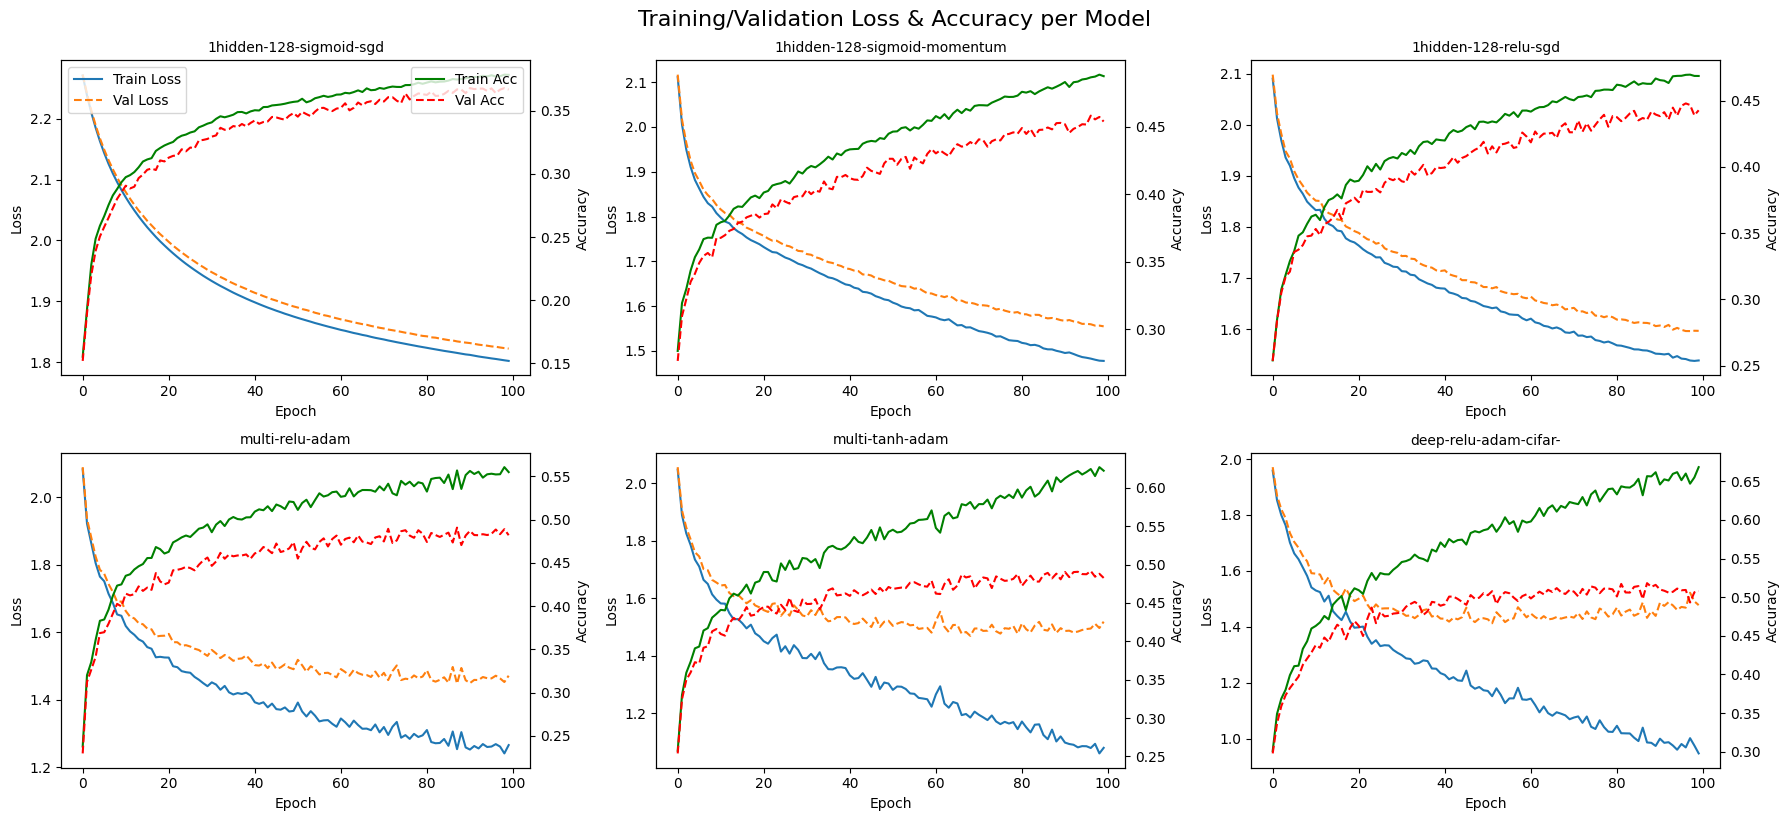

In [4]:
configs = [
    {
        "name": "1hidden-128-sigmoid-sgd",
        "layers": [Dense(128), Sigmoid(), Dense(10)],
        "optimizer": SGD(lr=0.01)
    },
    {
        "name": "1hidden-128-sigmoid-momentum",
        "layers": [Dense(128), Sigmoid(), Dense(10)],
        "optimizer": Momentum(lr=0.01)
    },
    {
        "name": "1hidden-128-relu-sgd",
        "layers": [Dense(128), ReLU(), Dense(10)],
        "optimizer": SGD(lr=0.01)
    },
    {
        "name": "multi-relu-adam",
        "layers": [Dense(128), ReLU(), Dense(64), ReLU(), Dense(10)],
        "optimizer": Adam(lr=0.001)
    },
    {
        "name": "multi-tanh-adam",
        "layers": [Dense(128), ActivationTanh(), Dense(64), ActivationTanh(), Dense(10)],
        "optimizer": Adam(lr=0.001)
    },
    {
        "name": "deep-relu-adam-cifar-",
        "layers": [Dense(256), ReLU(), Dense(128), ReLU(), Dense(10)],
        "optimizer": Adam(lr=0.001)
    }
]


results = {}
models = {}

for cfg in configs:
    print(f"\nTraining model: {cfg['name']}")
    model = Model(cfg["layers"])
    model.fit(
        x_train=x_train_flat,
        y_train=y_train_one_hot,
        epochs=100,
        batch_size=1024,
        loss=CategoricalCrossEntropy(),
        optimizer=cfg["optimizer"]
    )
    results[cfg["name"]] = model.evaluate(x_test_flat, y_test_one_hot)
    models[cfg["name"]] = model

plot_all_model_histories(models)


## Comprehensive Performance Analysis and Model Comparison

Detailed evaluation of all trained models using multiple performance metrics including loss, accuracy, macro-F1 score, confusion matrices, and classification reports. This analysis provides insights into the effectiveness of different architectural choices and optimization strategies for CIFAR-10 classification.

In [5]:
from sklearn.metrics import classification_report
import tensorflow as tf
import numpy as np

def classification_report_from_model(model, x_test_flat, y_test, y_test_one_hot):
    logits_tensor, _ = model._forward(
        tf.convert_to_tensor(x_test_flat, dtype=tf.float32),
        tf.convert_to_tensor(y_test_one_hot, dtype=tf.float32),
        training=False
    )
    y_pred_classes = np.argmax(logits_tensor.numpy(), axis=1)
    return y_pred_classes, classification_report(y_test, y_pred_classes, digits=4)

for name, model in models.items():
    metrics = model.evaluate(x_test_flat, y_test_one_hot)
    y_pred_classes, clf_report = classification_report_from_model(
        model, x_test_flat, y_test, y_test_one_hot
    )

    print(f"\n{'='*12}  {name}  {'='*12}")
    print(f"Loss        : {metrics['loss']:.4f}")
    print(f"Accuracy    : {metrics['accuracy']:.4f}")
    print(f"Macro-F1    : {metrics['f1_score']:.4f}")
    print("Confusion-matrix:")
    print(metrics['confusion_matrix'])
    print("\nClassification report:")
    print(clf_report)



============  1hidden-128-sigmoid-sgd  ============
Loss        : 1.8063
Accuracy    : 0.3778
Macro-F1    : 0.3697
Confusion-matrix:
[[484  51  38  15  11  26  29  51 229  66]
 [ 64 425  17  38  21  48  59  32 120 176]
 [150  46 189  75 132 103 158  70  47  30]
 [ 61  78  77 198  45 228 126  80  40  67]
 [ 71  40 118  52 276  89 206  93  32  23]
 [ 51  46  79 113  60 366 115  96  53  21]
 [ 23  57  76  85  82  91 479  41  15  51]
 [ 59  60  58  45 109  81  82 367  46  93]
 [153  89   9  18   6  55   4  24 519 123]
 [ 64 167  13  31  14  20  43  43 130 475]]

Classification report:
              precision    recall  f1-score   support

           0     0.4102    0.4840    0.4440      1000
           1     0.4013    0.4250    0.4128      1000
           2     0.2804    0.1890    0.2258      1000
           3     0.2955    0.1980    0.2371      1000
           4     0.3651    0.2760    0.3144      1000
           5     0.3306    0.3660    0.3474      1000
           6     0.3682    0.479